In [ ]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datasets import load_dataset

# Load dataset and metric assignments
ds = load_dataset("echo-bench/echo-bench", split="images_to_images")    
with open("../image_to_image_assigment.json", "r") as f:
    metric_assignments = json.load(f)

# Filter for samples with "No Color Shift" metric
idx_list = [idx for idx, s in enumerate(ds) if metric_assignments[str(idx)]["No Color Shift"] == 1]
ds = [s for idx, s in enumerate(ds) if metric_assignments[str(idx)]["No Color Shift"] == 1]
print(f"Number of samples with 'No Color Shift' metric: {len(ds)}")

Number of samples with 'No Color Shift' metric: 673


In [ ]:
def get_color_histogram(img: Image.Image) -> np.ndarray:
    """
    Get the color histogram of an image
    
    Args:
        img: PIL Image object
        
    Returns:
        numpy array of shape (3, 256) containing histograms for R, G, B channels
    """
    # Convert to RGB if not already
    rgb_img = img.convert("RGB")
    
    # Get RGB data as numpy array
    rgb_data = np.array(rgb_img)
    
    # Calculate histogram for each channel
    histograms = []
    for channel in range(3):  # R, G, B channels
        hist, _ = np.histogram(rgb_data[:, :, channel], bins=256, range=(0, 256))
        histograms.append(hist)
    
    return np.array(histograms)


def mean_rgb_from_hist(hist):
    """
    hist: (3, 256) normalized histogram for R/G/B
    returns (mean_r, mean_g, mean_b)
    """
    bins = np.arange(256)[5:251]  # consistent with your trimming
    mean_rgb = []
    for c in range(3):
        h = hist[c]
        mean = np.sum(bins * h)
        mean_rgb.append(mean)
    return mean_rgb

Histogram shape: (3, 256)
Sample histogram values (first 10 bins for Red channel): [2 1 0 0 0 1 0 0 4 4]


In [ ]:
# Extract color histograms from input images
all_hists_samples = {}
print("Extracting color histograms from input images...")

for idx, item in zip(idx_list, ds):
    try:
        img = item["input_images"][0]
        hist = get_color_histogram(img)
        all_hists_samples[idx] = hist
    except Exception as e:
        print(f"Error processing input image for idx {idx}: {e}")
        continue

print(f"Successfully processed {len(all_hists_samples)} input images")

In [17]:
input_hists = [hist for hist in all_hists_samples.values()]
input_hists_sum = np.sum(input_hists, axis=0) 
# normalize all_hists_sum, neglect the [0-5] bins and [251-256] bins
input_hists_sum = input_hists_sum[:, 5:251] / np.sum(input_hists_sum[:, 5:251], axis=1, keepdims=True)
print(mean_rgb_from_hist(input_hists_sum))


[130.19645545160165, 122.15157809824544, 113.10246908521974]


In [ ]:
import matplotlib.pyplot as plt

def visualize_color_histogram(hist, title="Color Histogram"):
    """
    Visualize the color histogram for R, G, B channels
    
    Args:
        hist: numpy array of shape (3, 256) containing histograms for R, G, B channels
        title: title for the plot
    """
    colors = ['red', 'green', 'blue']
    channel_names = ['Red', 'Green', 'Blue']
    
    plt.figure(figsize=(12, 8))
    
    # Plot all channels together
    plt.subplot(2, 1, 1)
    for i, (color, name) in enumerate(zip(colors, channel_names)):
        plt.plot(hist[i], color=color, alpha=0.7, label=f'{name} Channel')
    plt.title(f'{title} - All Channels')
    plt.xlabel('Pixel Intensity (0-255)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot channels separately
    plt.subplot(2, 1, 2)
    for i, (color, name) in enumerate(zip(colors, channel_names)):
        plt.subplot(2, 3, 4 + i)
        plt.bar(range(len(hist[i])), hist[i], color=color, alpha=0.7)
        plt.title(f'{name} Channel')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{title}.png")
    plt.show()
    # save the plot
    # plt.savefig(f"{title}.png")

# Visualize the histogram we just computed
visualize_color_histogram(hist, "Sample Image Color Histogram")



[129.7416086726352, 124.88083116909183, 112.35250602783229]


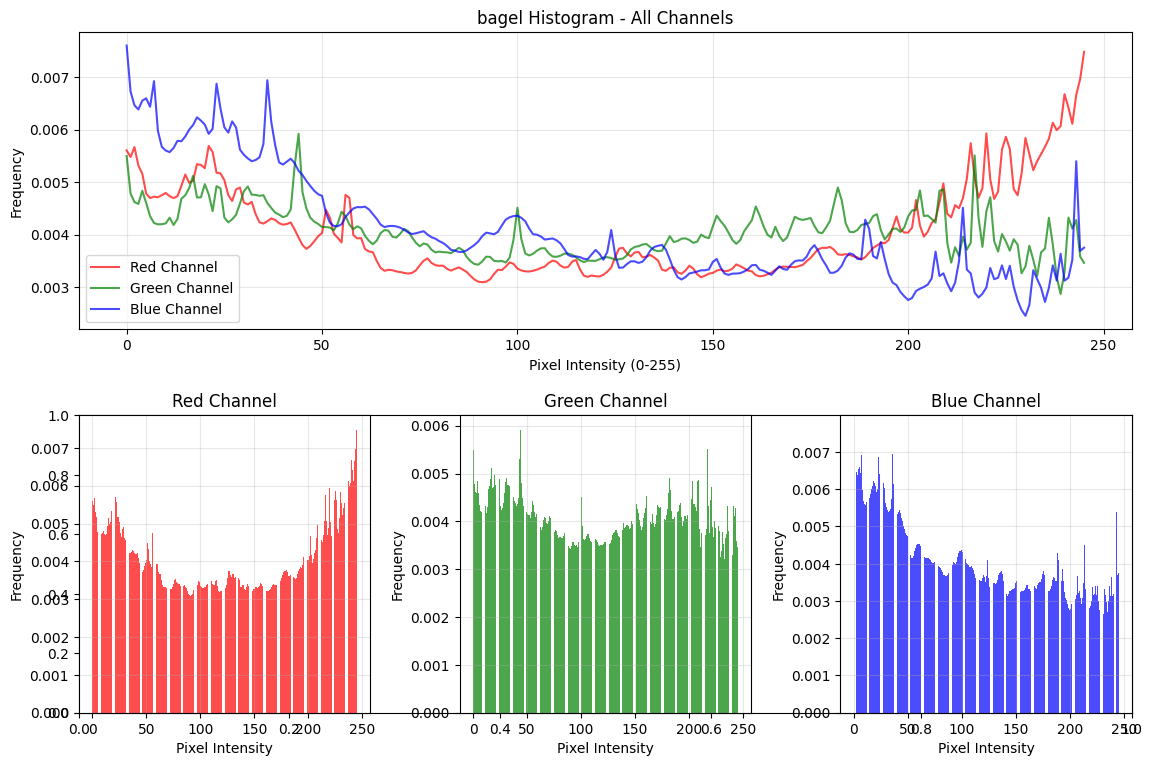

[130.04168497089918, 125.40240884087645, 110.29793663547314]


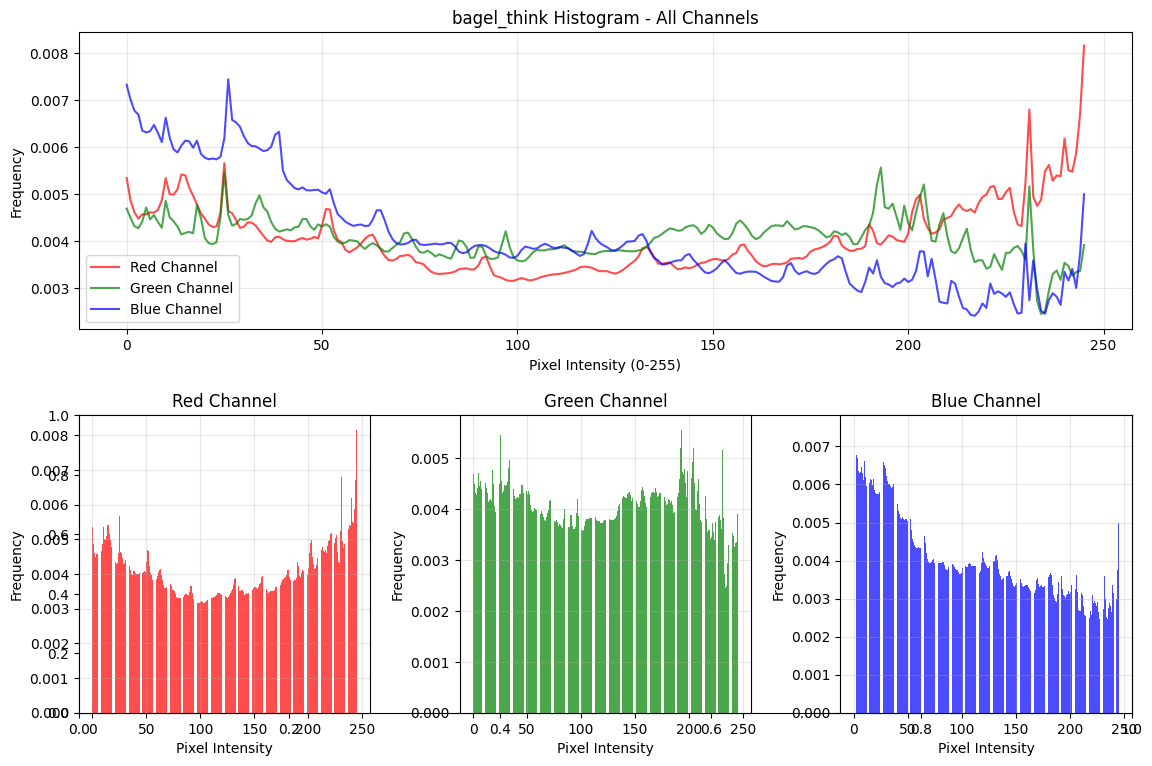

[121.31480320496527, 107.79034113129879, 91.08196395266762]


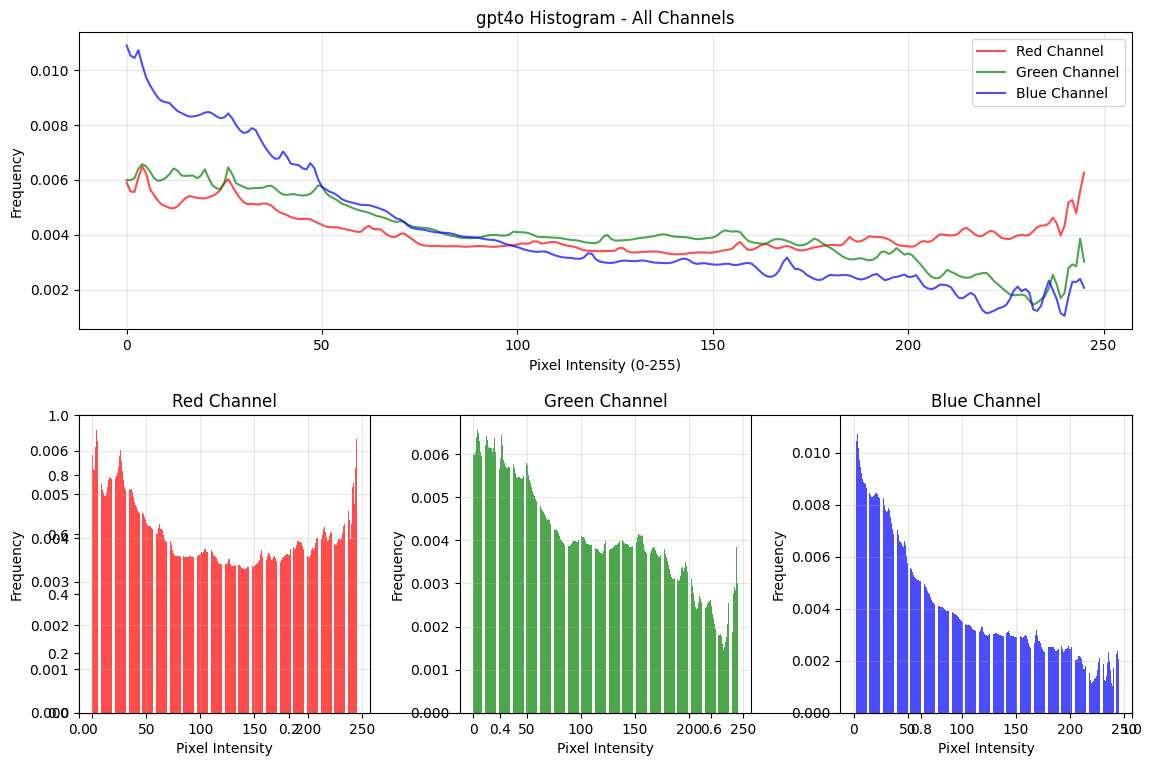

[126.83092896702428, 120.58596165155554, 111.25209817377942]


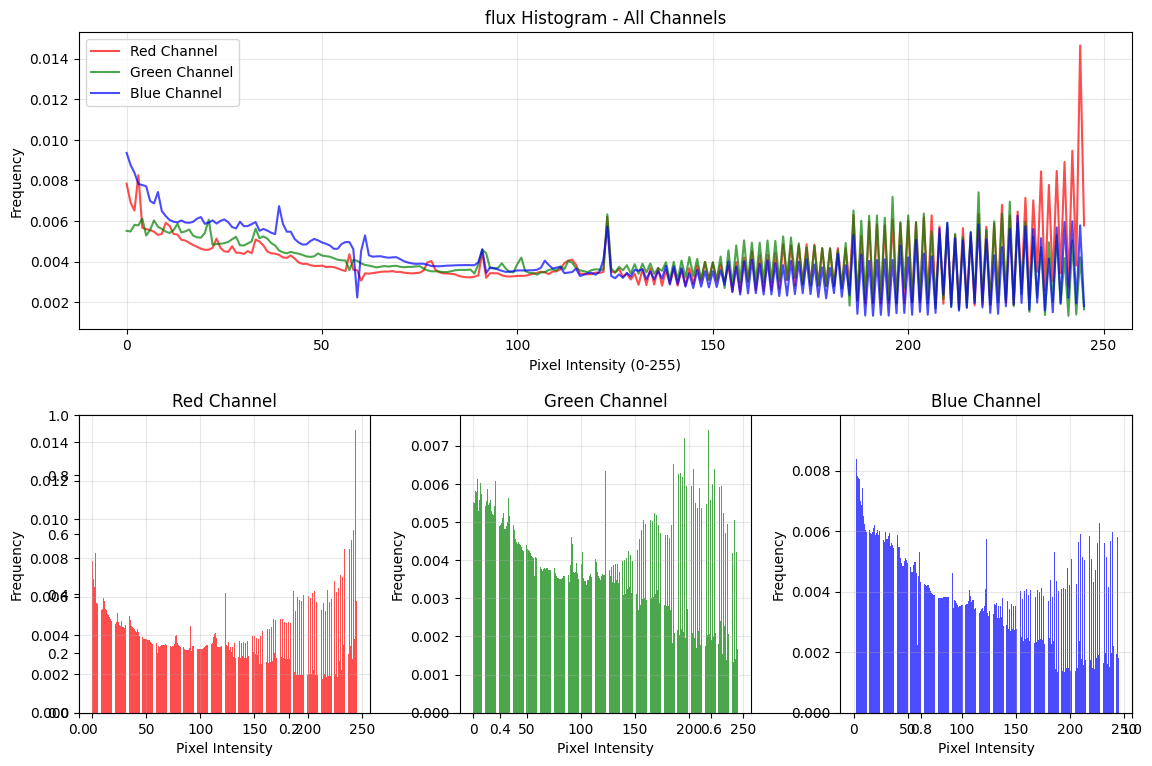

[130.6032150967758, 125.33250353180529, 116.92085934814034]


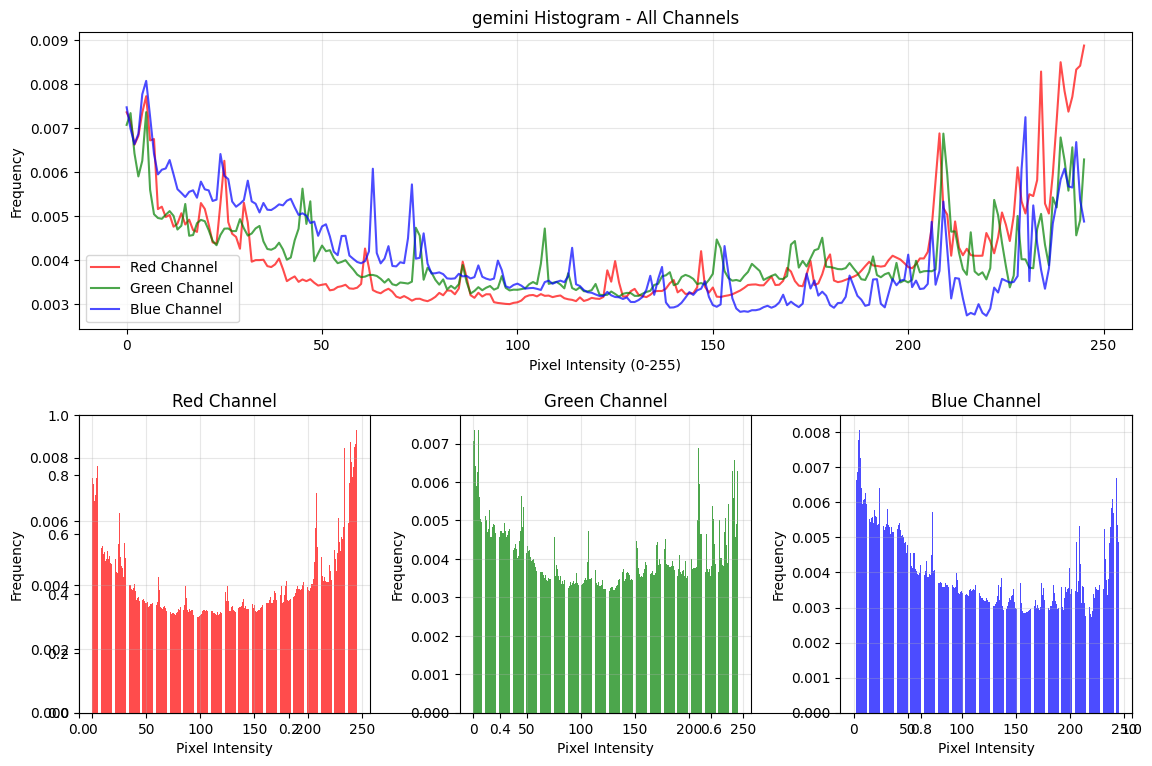

[128.8077440951207, 121.62224288530028, 113.30290608895706]


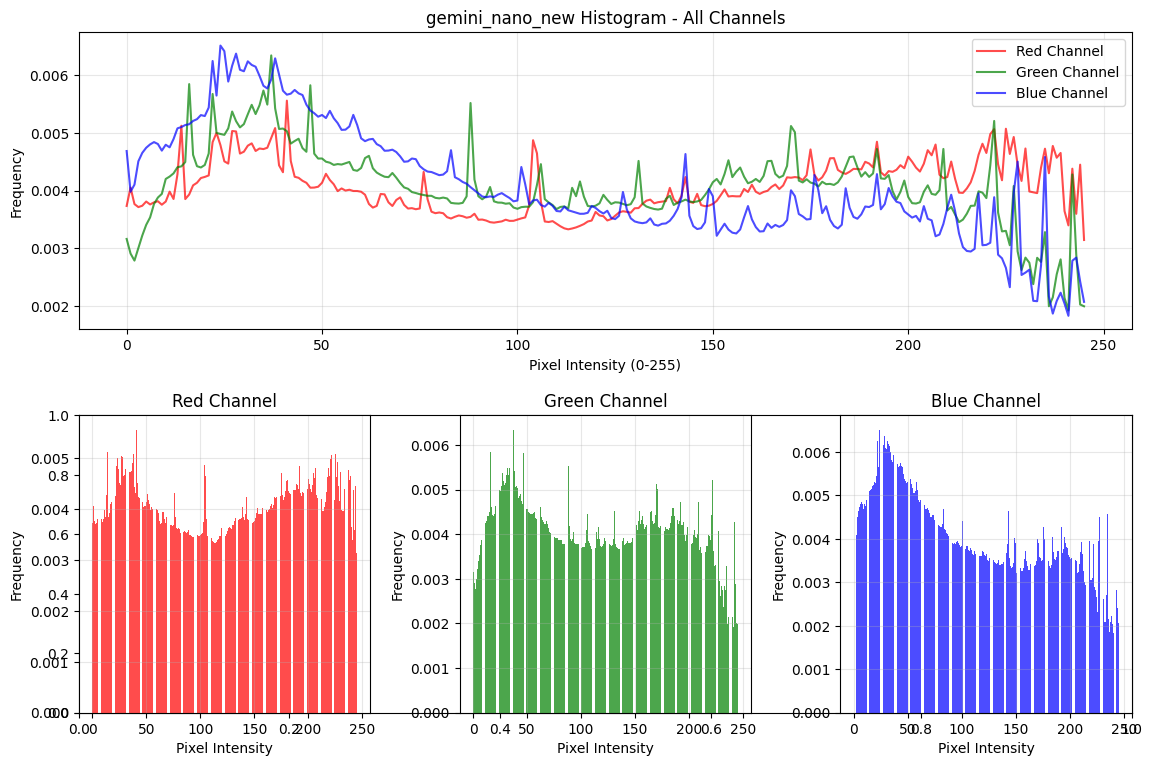

[122.2193817758066, 116.26410273544627, 105.57054995566492]


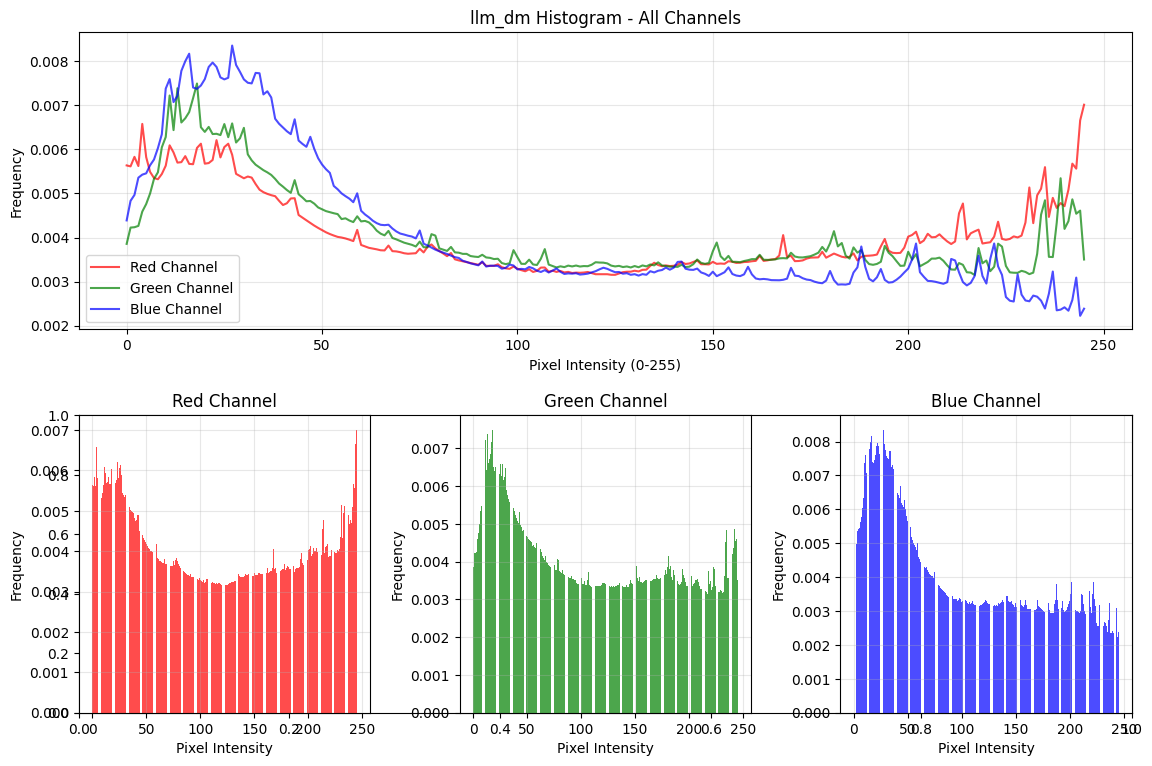

[128.71000201106853, 121.90663525468243, 115.90742617540042]


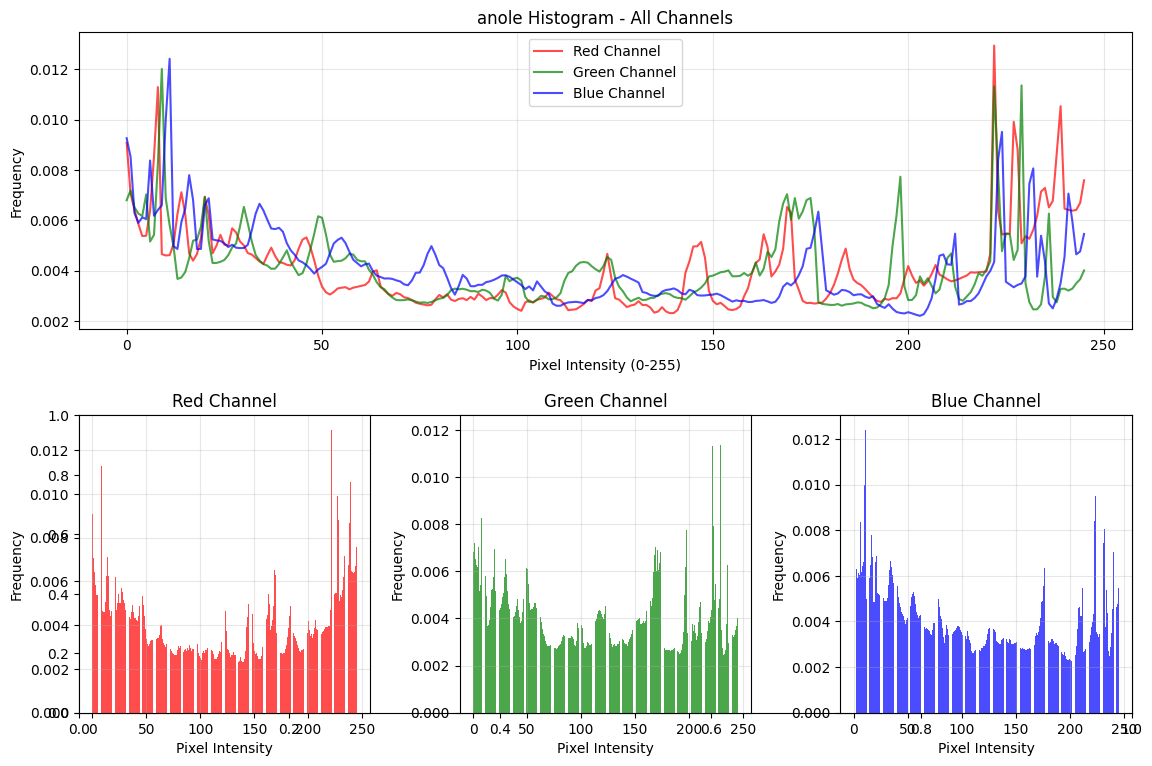

In [ ]:
# get histogram for all the output images for each model
import os
import json
import numpy as np
from PIL import Image
models = ["bagel", "bagel_think", "gpt4o", "flux", "gemini", "gemini_nano_new", "llm_dm", "anole"]
model = "gpt4o"
image_path = "../results/images_to_images"
def run_model_color(model):
    all_hists = []
    input_hists = []
    all_hists_diff = []
    for idx in idx_list:
        if os.path.exists(f"{image_path}/{idx}/{model}.png"):
            img = Image.open(f"{image_path}/{idx}/{model}.png")
            hist = get_color_histogram(img)
            all_hists.append(hist)
            

    all_hists = np.array(all_hists)
    # input_hists = np.array(input_hists)
    # take sum and normalize
    #(673, 3, 256) -> (3, 256)
    all_hists_sum = np.sum(all_hists, axis=0) 
    # normalize all_hists_sum, neglect the [0-5] bins and [251-256] bins
    all_hists_sum = all_hists_sum[:, 5:251] / np.sum(all_hists_sum[:, 5:251], axis=1, keepdims=True)
    print(mean_rgb_from_hist(all_hists_sum))
    # input_hists_sum = np.sum(input_hists, axis=0)
    visualize_color_histogram(all_hists_sum, title=f"{model} Histogram")
for model in models:
    run_model_color(model)


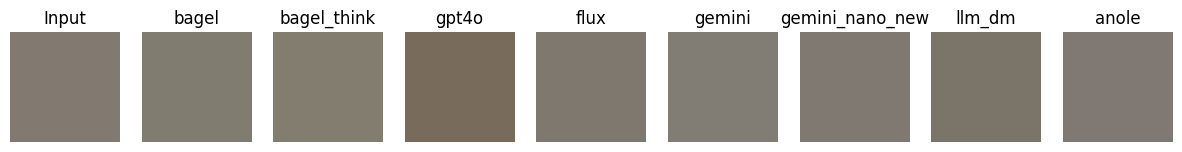

In [19]:
import numpy as np
import matplotlib.pyplot as plt

input_rgb = np.array([130.20, 122.15, 113.10]) / 255
models = {
    "bagel": [129.74, 124.88, 112.35],
    "bagel_think": [130.04, 125.40, 110.30],
    "gpt4o": [121.31, 107.79, 91.08],
    "flux": [126.83, 120.59, 111.25],
    "gemini": [130.60, 125.33, 116.92],
    "gemini_nano_new": [128.81, 121.62, 113.30],
    "llm_dm": [122.22, 116.26, 105.57],
    "anole": [128.71, 121.91, 115.91]
}

fig, ax = plt.subplots(1, len(models)+1, figsize=(15,2))
ax[0].imshow(np.ones((20,20,3)) * input_rgb)
ax[0].set_title("Input")
ax[0].axis("off")

for i, (name, rgb) in enumerate(models.items(), start=1):
    ax[i].imshow(np.ones((20,20,3)) * (np.array(rgb)/255))
    ax[i].set_title(name)
    ax[i].axis("off")

plt.show()
